#### Looking at the expression levels of groups of transcripts for salmon expression vals within simulation databases

In [1]:
import sqlite3
import pandas as pd
import math
import numpy as np

cnx = sqlite3.connect('/shared/sudlab1/General/projects/utrons_project/Simulations/SimulationUtronsQuant/SimulationUtrons.salmon.db') # connect to salmon db
cnx.execute("ATTACH '/shared/sudlab1/General/annotations/hg38_noalt_ensembl85/csvdb' as annotations") # attach annotations

In [2]:
"""
Get Salmon Tpms
"""

def salmonTpms(sample, runnum):

    #  query1 = Ensembl genes
    query_text1 = '''
    SELECT name, TPM
    FROM salmon_quant AS q
    WHERE q.track="'''+sample+'''" AND Name like "ENS%"
    ORDER BY name
    '''
    
    # query2 = stringtie genes
    query_text2 = '''
    SELECT name, TPM
    FROM salmon_quant AS q
    WHERE q.track="'''+sample+'''" AND name like "MSTRG%"
    ORDER BY name
    '''
    
    # query3 = novel UTRon genes
    query_text3 = '''
    SELECT name, TPM
    FROM salmon_quant AS q
    INNER JOIN novel_utrons_ids AS uid
    ON q.name=uid.transcript_id
    WHERE q.track="'''+sample+'''" AND name like "MSTRG%" AND uid.track="agg-agg-agg"
    ORDER BY name
    '''
     
    # Get tpms for ensembl, stringtie and utron genes into dataframes
    enstpms = pd.read_sql_query(query_text1, cnx) 
    mstrgtpms = pd.read_sql_query(query_text2, cnx)
    utrontpms = pd.read_sql_query(query_text3, cnx)
    
    # If creating initial dataframe, drop FPKMs but keep t_names
    if runnum == 1:
        pass
    # Else drop tx names
    else:
        enstpms.drop(['Name'], axis=1, inplace=True)
        mstrgtpms.drop(['Name'], axis=1, inplace=True)
        utrontpms.drop(['Name'], axis=1, inplace=True)
        
    return enstpms, mstrgtpms, utrontpms



# Create initial dataframe by passing runnum == 1 and sample = GC-WT-1
salmonEnsembl, salmonMstrg, salmonUtron = salmonTpms("GC-WT-1", 1)

# Loop through remaining samples and concatenate databases together
for num in range(2,41,1):
    sample = "GC-WT-" + str(num)
    ens, mstrg, utron = salmonTpms(sample, 0)
    salmonEnsembl = pd.concat([salmonEnsembl, ens],axis=1)
    salmonMstrg = pd.concat([salmonMstrg, mstrg],axis=1)
    salmonUtron = pd.concat([salmonUtron, utron],axis=1)

In [19]:
"""
Get gene Averages before plotting
"""
def getAverage(row):
    return row.ix[1:].sum() / len(row.ix[1:])
    
def logList(values):
    values = np.log(values)
    return values
    
# Get gene averages    
salmonUtron["average"] = salmonUtron.apply(getAverage, axis=1)
salmonEnsembl["average"] = salmonEnsembl.apply(getAverage, axis=1)
salmonMstrg["average"] = salmonMstrg.apply(getAverage, axis=1)

# Log gene averages
utrons = logList(salmonUtron["average"].tolist())
ensembl = logList(salmonEnsembl["average"].tolist())
mstrg = logList(salmonMstrg["average"].tolist())

/home/mba13ns/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


In [52]:
"""
Get  log average of averages 
"""
ensemblAverage = salmonEnsembl["average"].tolist()
ensemblAverage = sum(ensemblAverage)/len(ensemblAverage)
ensemblAverage = np.log(ensemblAverage)

mstrgAverage = salmonMstrg["average"].tolist()
mstrgAverage = sum(mstrgAverage)/len(mstrgAverage)
mstrgAverage = np.log(mstrgAverage)

utronAverage = salmonUtron["average"].tolist()
utronAverage = sum(utronAverage)/len(utronAverage)
utronAverage = np.log(utronAverage)

Populating the interactive namespace from numpy and matplotlib


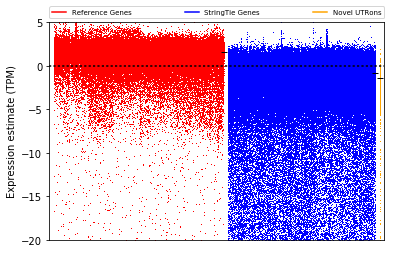

In [79]:
%pylab inline
# Count number of genes in each list
numEnsembl = len(ensembl); numUtrons = len(utrons); numMstrg = len(mstrg)

# Make ranges to plot values
ensemblRange = range(5000, numEnsembl+5000, 1); maxens = max(ensemblRange) + 5000
mstrgRange = range(maxens, maxens+numMstrg, 1); maxmstrg = max(mstrgRange) + 5000
utronRange = range(maxmstrg, maxmstrg+numUtrons, 1); maxutron = max(utronRange) + 5000

# Plot values
pylab.plot(ensemblRange, ensembl, ',', color="red")
pylab.plot(mstrgRange, mstrg, ',', color="blue")
pylab.plot(utronRange, utrons, ',', color="orange")

# Plot Averages for each group
pylab.plot(maxens-5000,ensemblAverage, '_', color="black")
pylab.plot(maxmstrg-5000,mstrgAverage, '_', color="black")
pylab.plot(maxutron-5000,utronAverage, '_', color="black")


# Set figure legend and horizontal line at 0
pylab.plot(0,0, color="red", label="Reference Genes")
pylab.plot(0,0, color="blue", label="StringTie Genes")
pylab.plot(0,0, color="orange", label="Novel UTRons")
pylab.plot([0,maxutron], [0,0],":k", color='black')


# Figure Options
pylab.xlim(0, maxutron)
pylab.ylim(-20, 5)
pylab.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=5, mode="expand", borderaxespad=0.,fontsize='x-small')
pylab.ylabel("Expression estimate (TPM)")
pylab.tick_params(axis='x', which='both', bottom='off',top='off',labelbottom='off') 

pylab.savefig("./images/7_SimulationExpression", dpi=500)

- Stringtie expression levels look < than reference levels and UTRons are << than reference

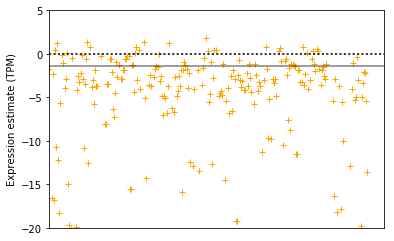

In [91]:
pylab.plot(utrons, '+', color="orange")
pylab.plot([0,300], [utronAverage]*2, color="black", alpha=0.5)
pylab.plot([0,300], [0,0], ':k')
pylab.xlim(0,300)
pylab.ylim(-20,5)
pylab.ylabel("Expression estimate (TPM)")

pylab.tick_params(axis='x', which='both', bottom='off',top='off',labelbottom='off') 
pylab.savefig("images/7_UtronExpression.png", dpi=300)

- zoom in of utrons show most are below the 1 tpm line